In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 190 GB / percent used: 24.4 %


In [ ]:
client.close()

In [2]:
# For parallelisation
from dask.distributed import Client
# client = Client(n_workers=4, threads_per_worker=1, memory_limit='4GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:32870 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


# Check model data

In [3]:
path = '/thredds/tgcc/store/p86caub/ICOLMDZOR/PROD/highresSST-present/CM7A-HR-v1.11.highresSST-present'
path_CM6 = '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1'

folder = 'SRF'
var_LMDZ = 'frac_snow'

var = 'snc'
table = 'LImon'

In [6]:
xr.open_dataset(path+'/'+folder+'/Analyse/TS_MO/CM7A-HR-v1.11.highresSST-present_19500101_20141231_1M_'+var_LMDZ+'.nc')

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lat: 360, lon: 720, time_counter: 780)
Coordinates:
  * lat                   (lat) float32 -90.0 -89.498604 ... 89.498604 90.0
  * lon                   (lon) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 1950-01-16T12:00:00 ....
Dimensions without coordinates: axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    Areas                 (lat, lon) float32 ...
    Contfrac              (lat, lon) float32 ...
    frac_snow             (time_counter, lat, lon) float32 ...
Attributes:
    name:         sechiba_history
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Jan-24 08:26:06 GMT
    uuid:         df84bd4e-118e-421f-9b7f-244e0c536f0f
    LongName:     IPSLCM6.1.11-LR

In [ ]:
xr.open_dataset(path_CM6+'/'+table+'/'+var+'/gr/latest/'+var+'_'+table+'_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc')

In [ ]:
xr.open_dataset(path+'/'+folder+'/Analyse/TS_MO/CM7A-HR-v1.11.highresSST-present_19500101_20141231_1M_'+var_LMDZ+'.nc')[var_LMDZ].mean('time_counter').plot()

In [ ]:
xr.open_dataset(path_CM6+'/'+table+'/'+var+'/gr/latest/'+var+'_'+table+'_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc')[var].mean('time').plot()

# Define period and zone

In [4]:
# Define common period -> smaller period because MODIS only from March 2000
period = slice('2001','2014')

# Define zone
latlim=(-90,90)
lonlim=(0,360)

var = 'snc'
label = 'Snow cover extent'
units = '%'
cmap='viridis'
levels=plot.arange(0,100,10)

# Get model data dynamico and HR CM6

In [5]:
model_CM7 = xr.open_dataset(
    path+'/'+folder+'/Analyse/TS_MO/CM7A-HR-v1.11.highresSST-present_19500101_20141231_1M_'+var_LMDZ+'.nc'
)[var_LMDZ].sel(time_counter=period)
model_CM7 = model_CM7.rename({'time_counter': 'time'})
model_CM7

<xarray.DataArray 'frac_snow' (time: 168, lat: 360, lon: 720)>
[43545600 values with dtype=float32]
Coordinates:
  * lat            (lat) float32 -90.0 -89.498604 -88.997215 ... 89.498604 90.0
  * lon            (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
    time_centered  (time) datetime64[ns] ...
  * time           (time) datetime64[ns] 2001-01-16T12:00:00 ... 2014-12-16T1...
Attributes:
    long_name:           Snow fraction on total area including snow on vegeta...
    units:               %
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_methods:        time: mean

In [6]:
model_CM6 = xr.open_dataset(
    path_CM6+'/'+table+'/'+var+'/gr/latest/'+var+'_'+table+'_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc'
)[var].sel(time=period)
model_CM6

<xarray.DataArray 'snc' (time: 168, lat: 361, lon: 512)>
[31051776 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time     (time) datetime64[ns] 2001-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

# Compute climatologies

In [7]:
calendar = model_CM7.time.encoding['calendar']
calendar

'gregorian'

In [8]:
model_CM6_clim = u.clim(model_CM6, calendar=calendar)
model_CM7_clim = u.clim(model_CM7, calendar=calendar)

# Load obs
## MODIS/Terra Snow Cover Monthly L3 Global 0.05Deg CMG, Version 6

Check http://localhost:7227/tree/notebooks/Observations/MODIS/MOD10CM for pretreatment (hdf -> netcdf)

https://nsidc.org/data/MOD10CM

Grid
The MODIS CMG consists of 7200 columns by 3600 rows. Each cell has a resolution of 0.05 degrees (approximately 5 km). The upper-left corner of the upper-left cell is -180.00 degrees longitude, 90.00 degrees latitude. The lower-right corner of the lower right cell is -180.00 degrees longitude, -90.00 degrees latitude. For additional details about the MODIS Climate Modeling Grid, see the NASA MODIS Lands | MODIS Grids Web page.

The following resources can help you select and work with gridded MODIS data:

HDF-EOS to GeoTIFF Conversion Tool (HEG)

Other products: https://modis.gsfc.nasa.gov/data/dataprod/mod10.php  
More info on grids: https://modis-land.gsfc.nasa.gov/MODLAND_grid.html

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


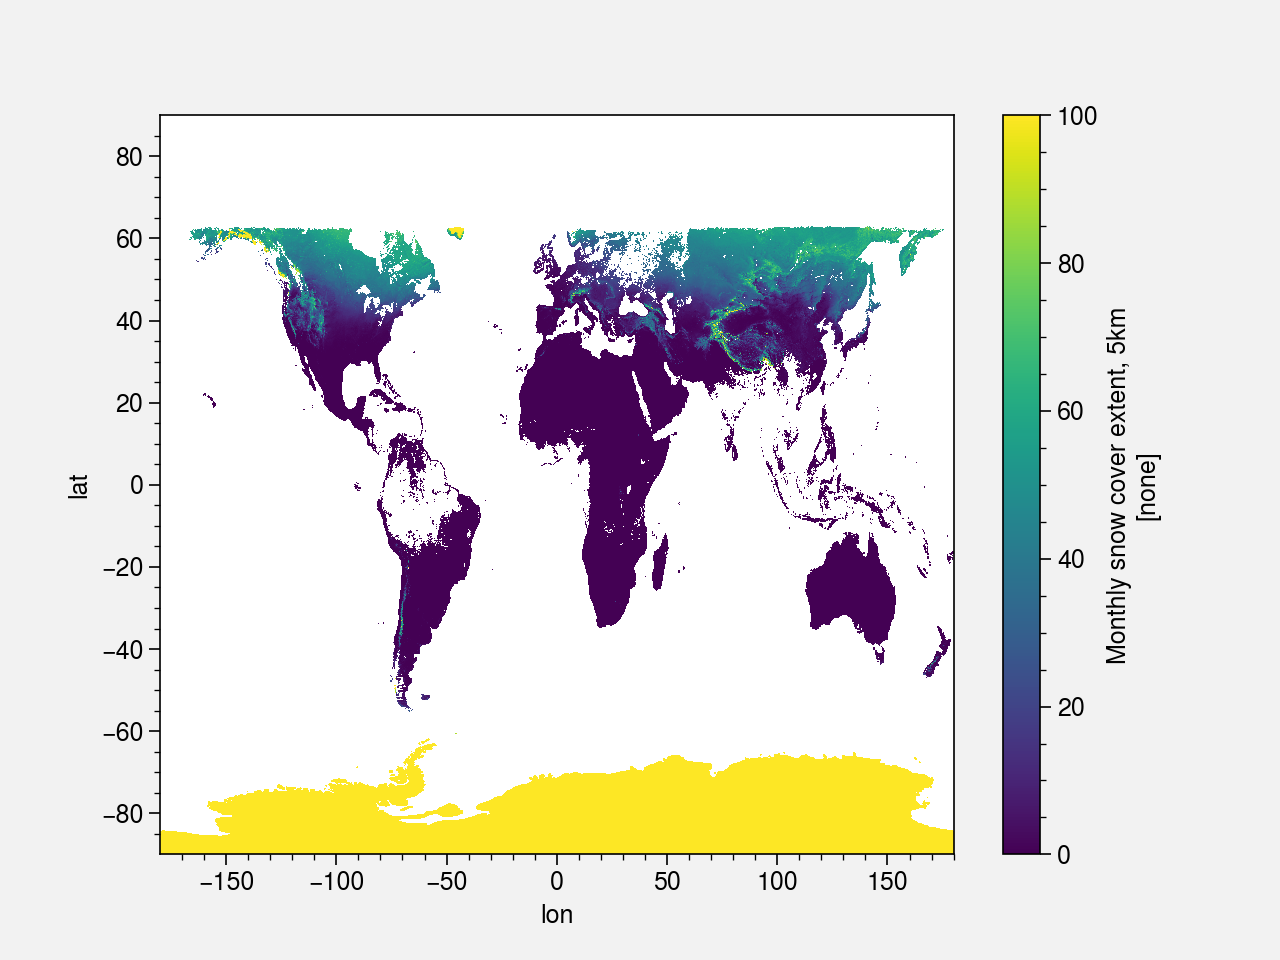

In [22]:
# obs_longname = 'MODIS/Terra Snow Cover Monthly L3 Global 0.05Deg CMG, Version 6'
# obs_name = 'MOD10C1'

# obs = xr.open_mfdataset('/data/mlalande/MODIS/MOD10CM/netcdf/*.nc', combine='by_coords').sel(time=period).Snow_Cover_Monthly_CMG
# obs = obs.where(obs <= 100)
# obs_clim = u.clim(obs, calendar='gregorian')
# obs_clim.plot()

In [9]:
%%time
obs_longname = 'MODIS/Terra Snow Cover Monthly L3 Global 0.05Deg CMG, Version 6'
obs_name = 'MOD10C1'

obs = xr.open_mfdataset('/data/mlalande/MODIS/MOD10CM/netcdf/*.nc', combine='by_coords').sel(time=period).Snow_Cover_Monthly_CMG
obs = obs.where(obs <= 100).coarsen(lat=10, lon=10).mean()
obs_clim = (u.clim(obs, calendar='gregorian', skipna=True)).load()

CPU times: user 25.3 s, sys: 4.17 s, total: 29.4 s
Wall time: 1min 32s


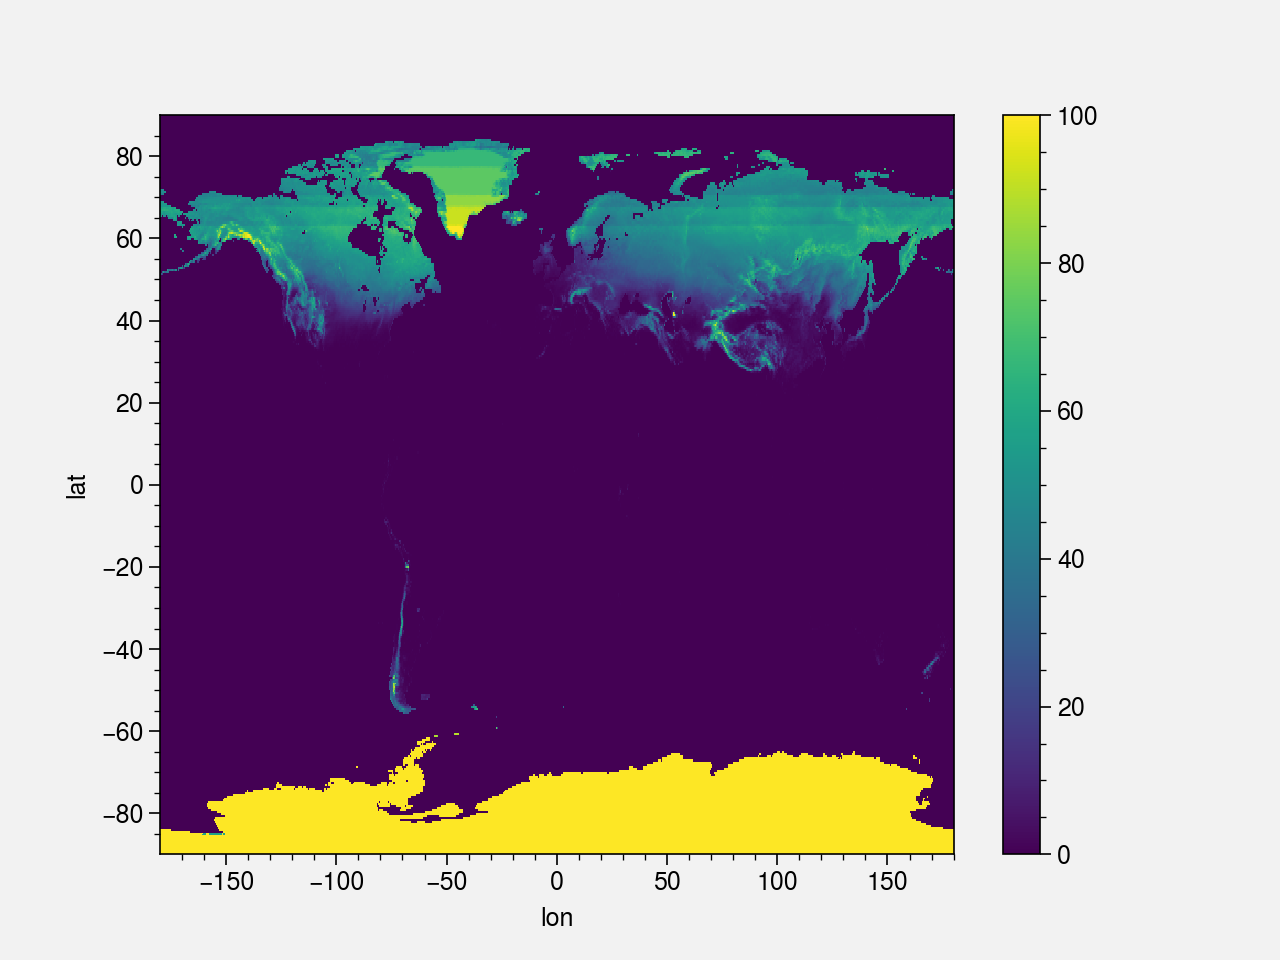

In [10]:
obs_clim.plot()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


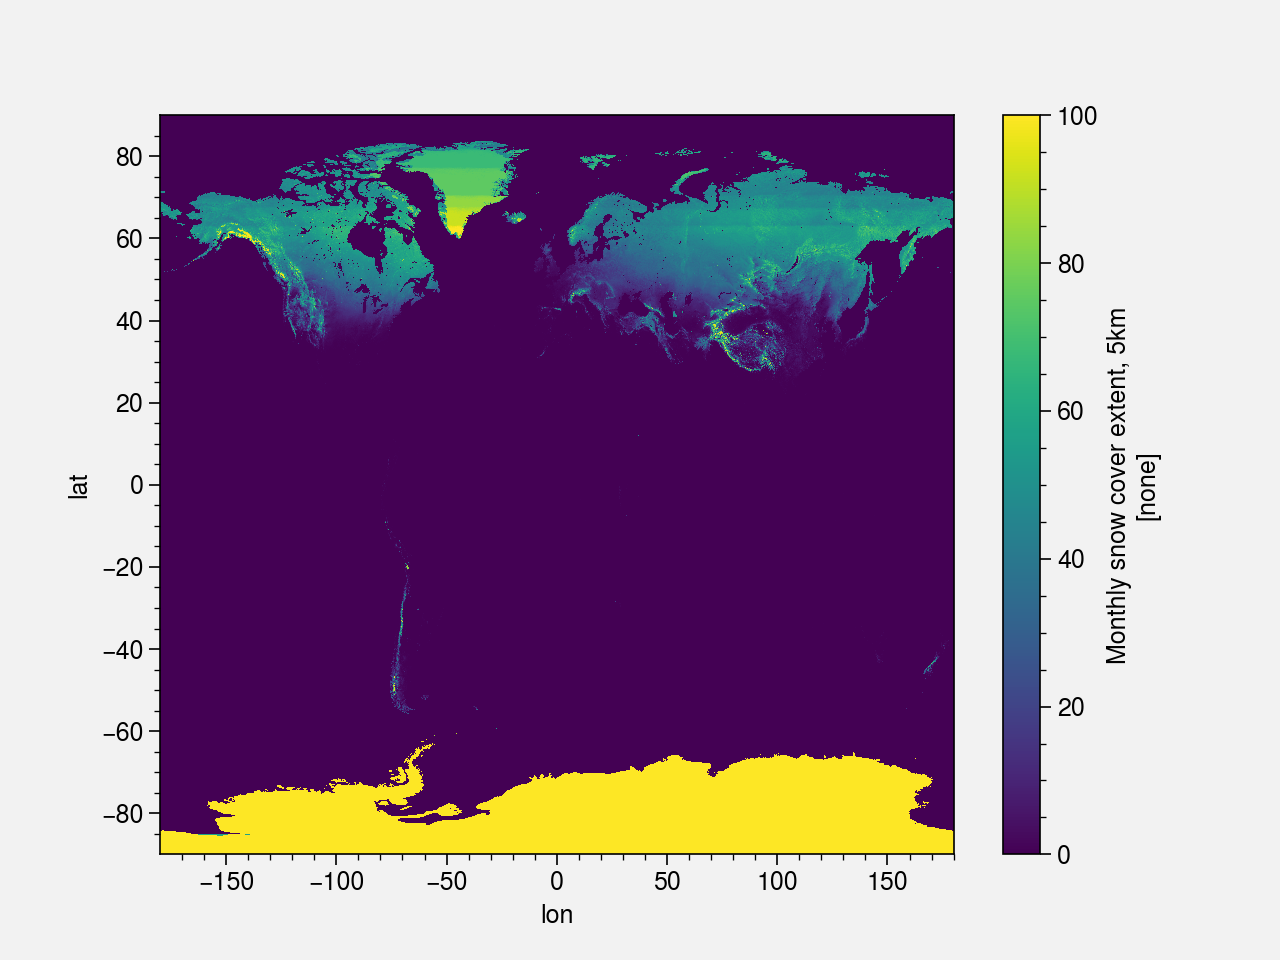

In [23]:
# obs_clim.plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

Regrid towards HR-CM6 with lower resolution

In [16]:
regridder_obs = xe.Regridder(obs_clim, model_CM6_clim, 'bilinear', periodic=True, reuse_weights=False)
obs_clim_regrid = regridder_obs(obs_clim)

# reuse_weights=False car déjà fichier qui a le même nom
regridder_CM7 = xe.Regridder(model_CM7_clim, model_CM6_clim, 'bilinear', periodic=True, reuse_weights=False)
model_CM7_clim_regrid = regridder_CM7(model_CM7_clim)

Overwrite existing file: bilinear_360x720_361x512_peri.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_360x720_361x512_peri.nc 
 You can set reuse_weights=True to save computing time.


# Plot differences

In [19]:
obs_clim_regrid

<xarray.DataArray (lat: 361, lon: 512)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Attributes:
    regrid_method:  bilinear

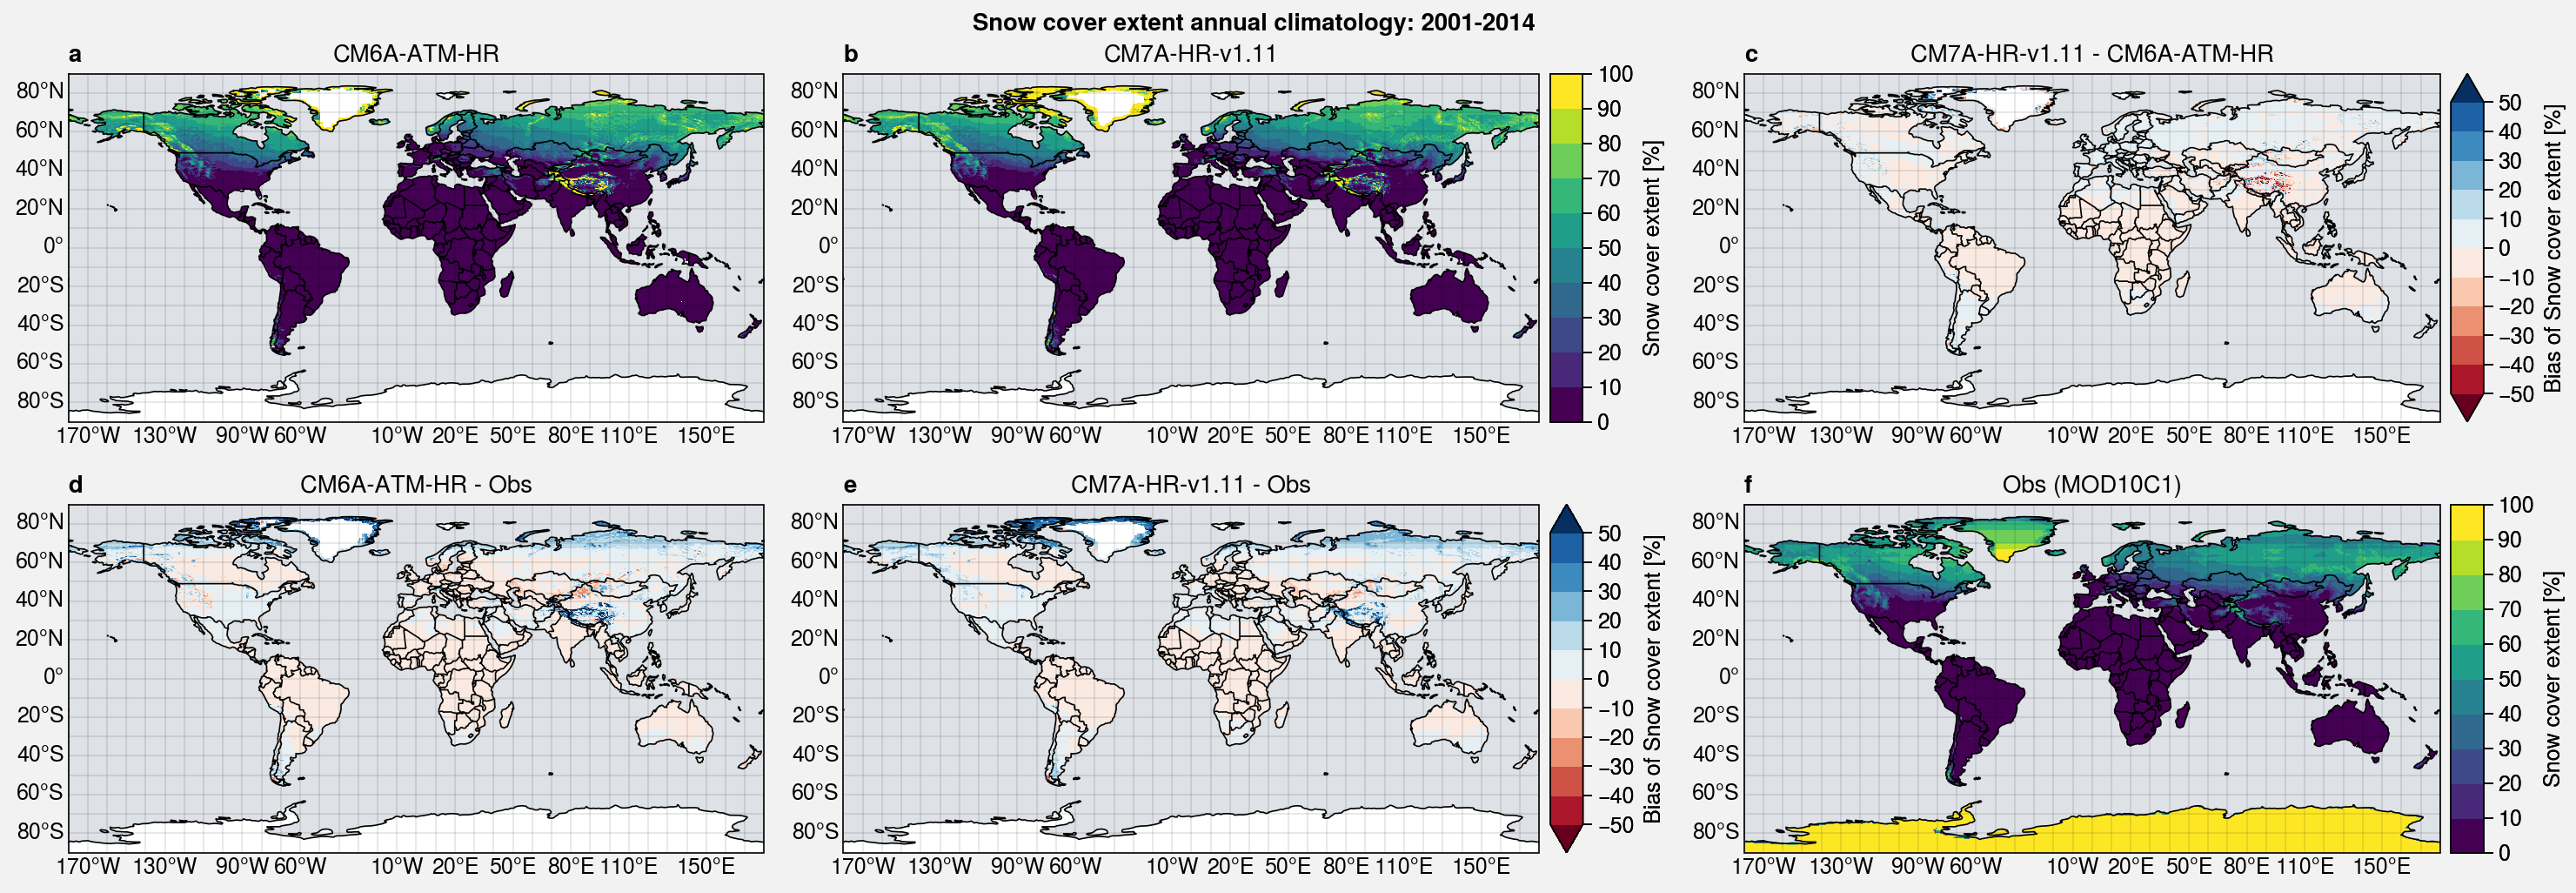

In [18]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2, axwidth=4)

levels_diff = plot.arange(-50,50,10)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

# First row: differences CM7A-HR-v1.11 / not guide
axs[0].pcolormesh(model_CM6_clim, cmap=cmap, levels=levels)
axs[0].format(title='CM6A-ATM-HR')

m1 = axs[1].pcolormesh(model_CM7_clim, cmap=cmap, levels=levels)
axs[1].format(title='CM7A-HR-v1.11')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_CM7_clim_regrid - model_CM6_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='CM7A-HR-v1.11 - CM6A-ATM-HR')
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: differences with obs

axs[3].pcolormesh(model_CM6_clim - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[3].format(title='CM6A-ATM-HR - Obs')

axs[4].pcolormesh(model_CM7_clim_regrid - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[4].format(title='CM7A-HR-v1.11 - Obs')
axs[4].colorbar(m2, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
#     geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, 
    labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.pdf')

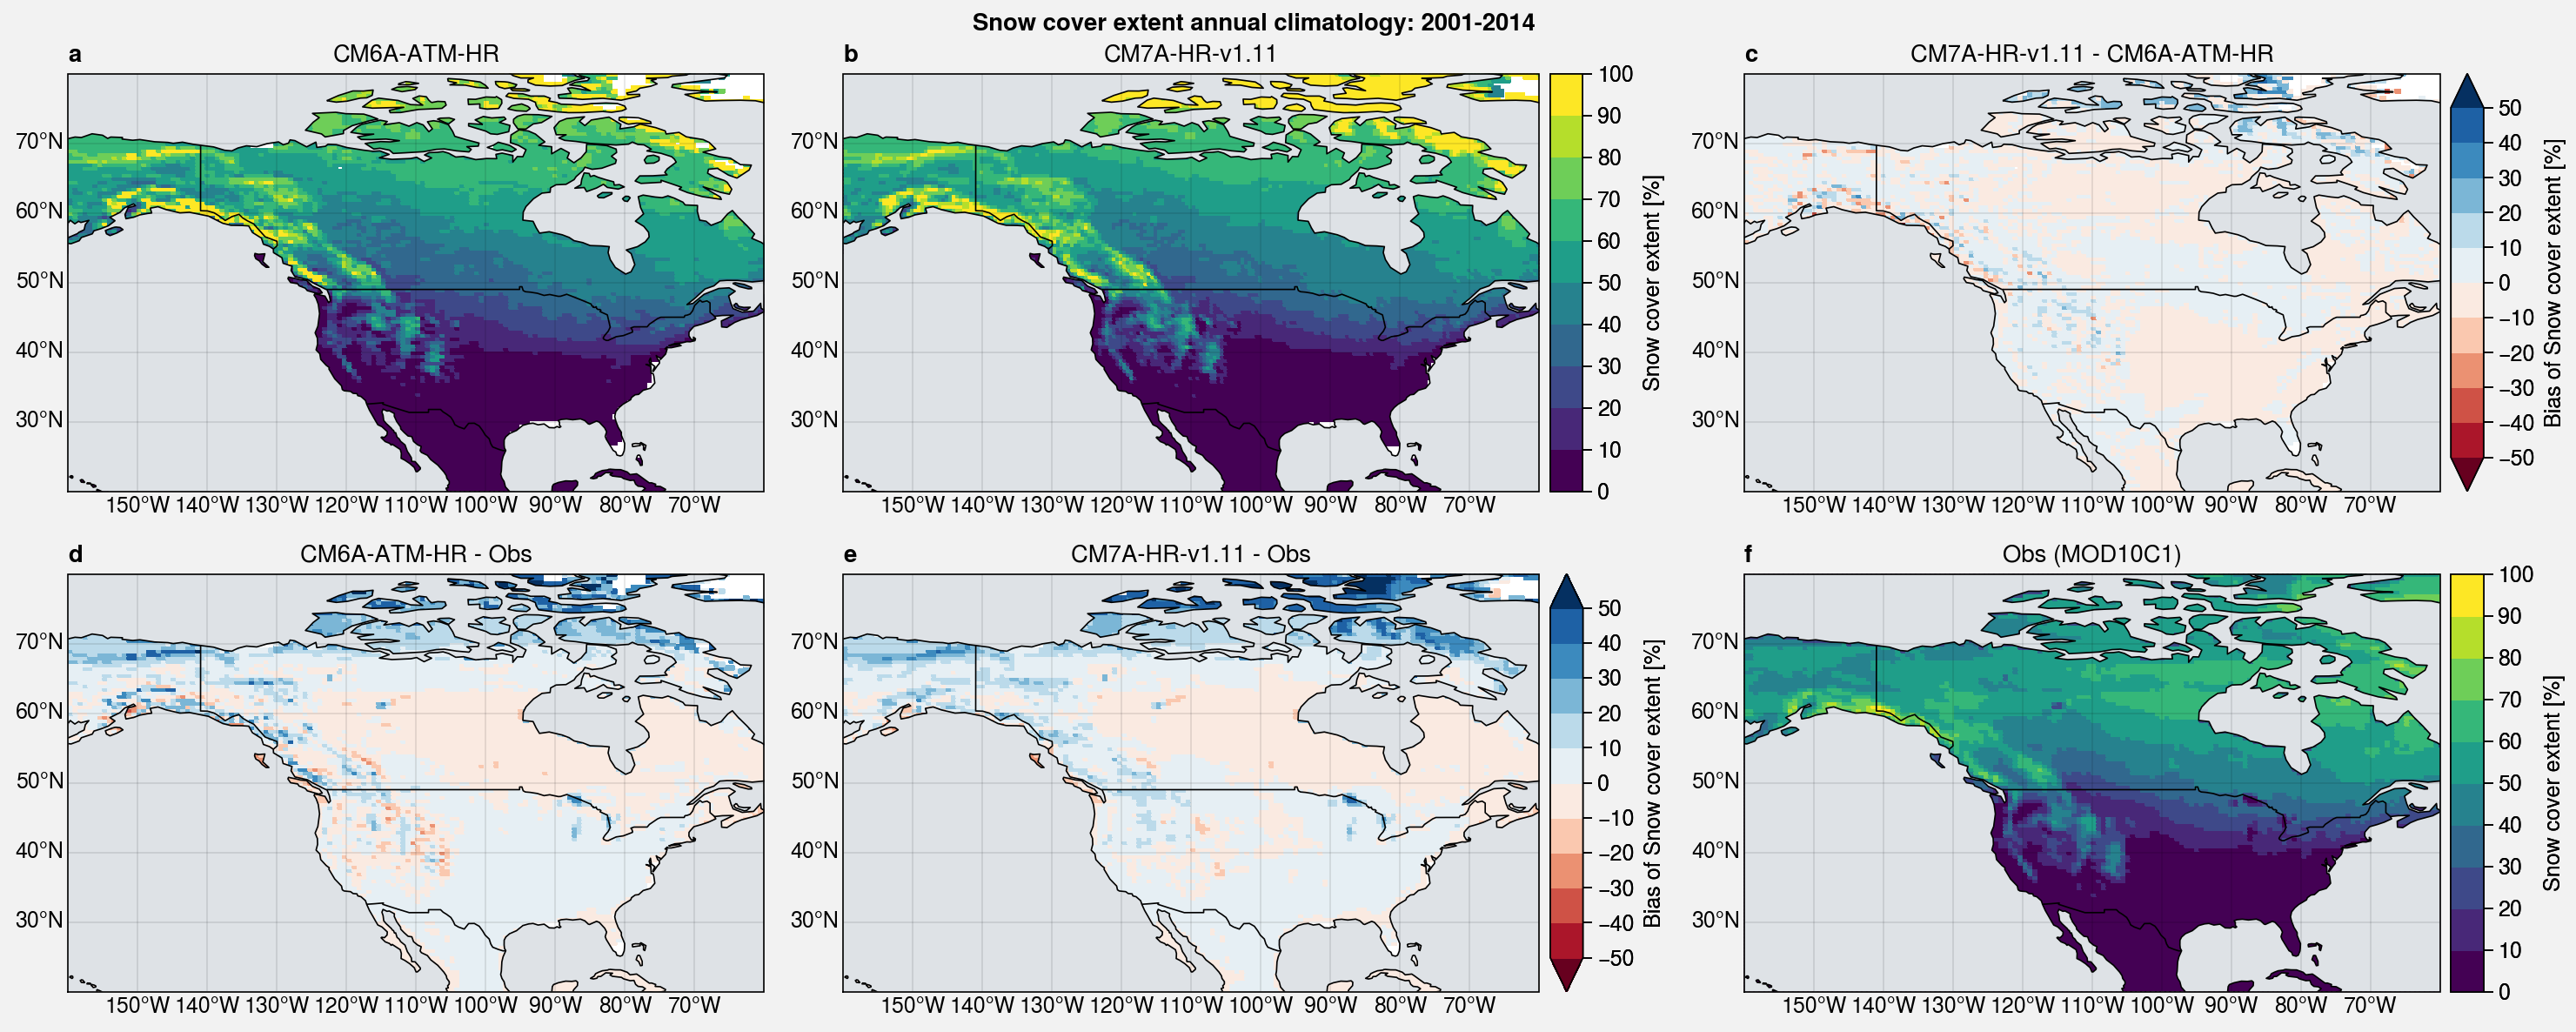

In [20]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2, axwidth=4)

levels_diff = plot.arange(-50,50,10)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

# First row: differences CM7A-HR-v1.11 / not guide
axs[0].pcolormesh(model_CM6_clim, cmap=cmap, levels=levels)
axs[0].format(title='CM6A-ATM-HR')

m1 = axs[1].pcolormesh(model_CM7_clim, cmap=cmap, levels=levels)
axs[1].format(title='CM7A-HR-v1.11')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_CM7_clim_regrid - model_CM6_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='CM7A-HR-v1.11 - CM6A-ATM-HR')
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: differences with obs

axs[3].pcolormesh(model_CM6_clim - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[3].format(title='CM6A-ATM-HR - Obs')

axs[4].pcolormesh(model_CM7_clim_regrid - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[4].format(title='CM7A-HR-v1.11 - Obs')
axs[4].colorbar(m2, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
#     geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, 
    labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=(20, 80), lonlim=(200, 300)
)

# f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.pdf')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


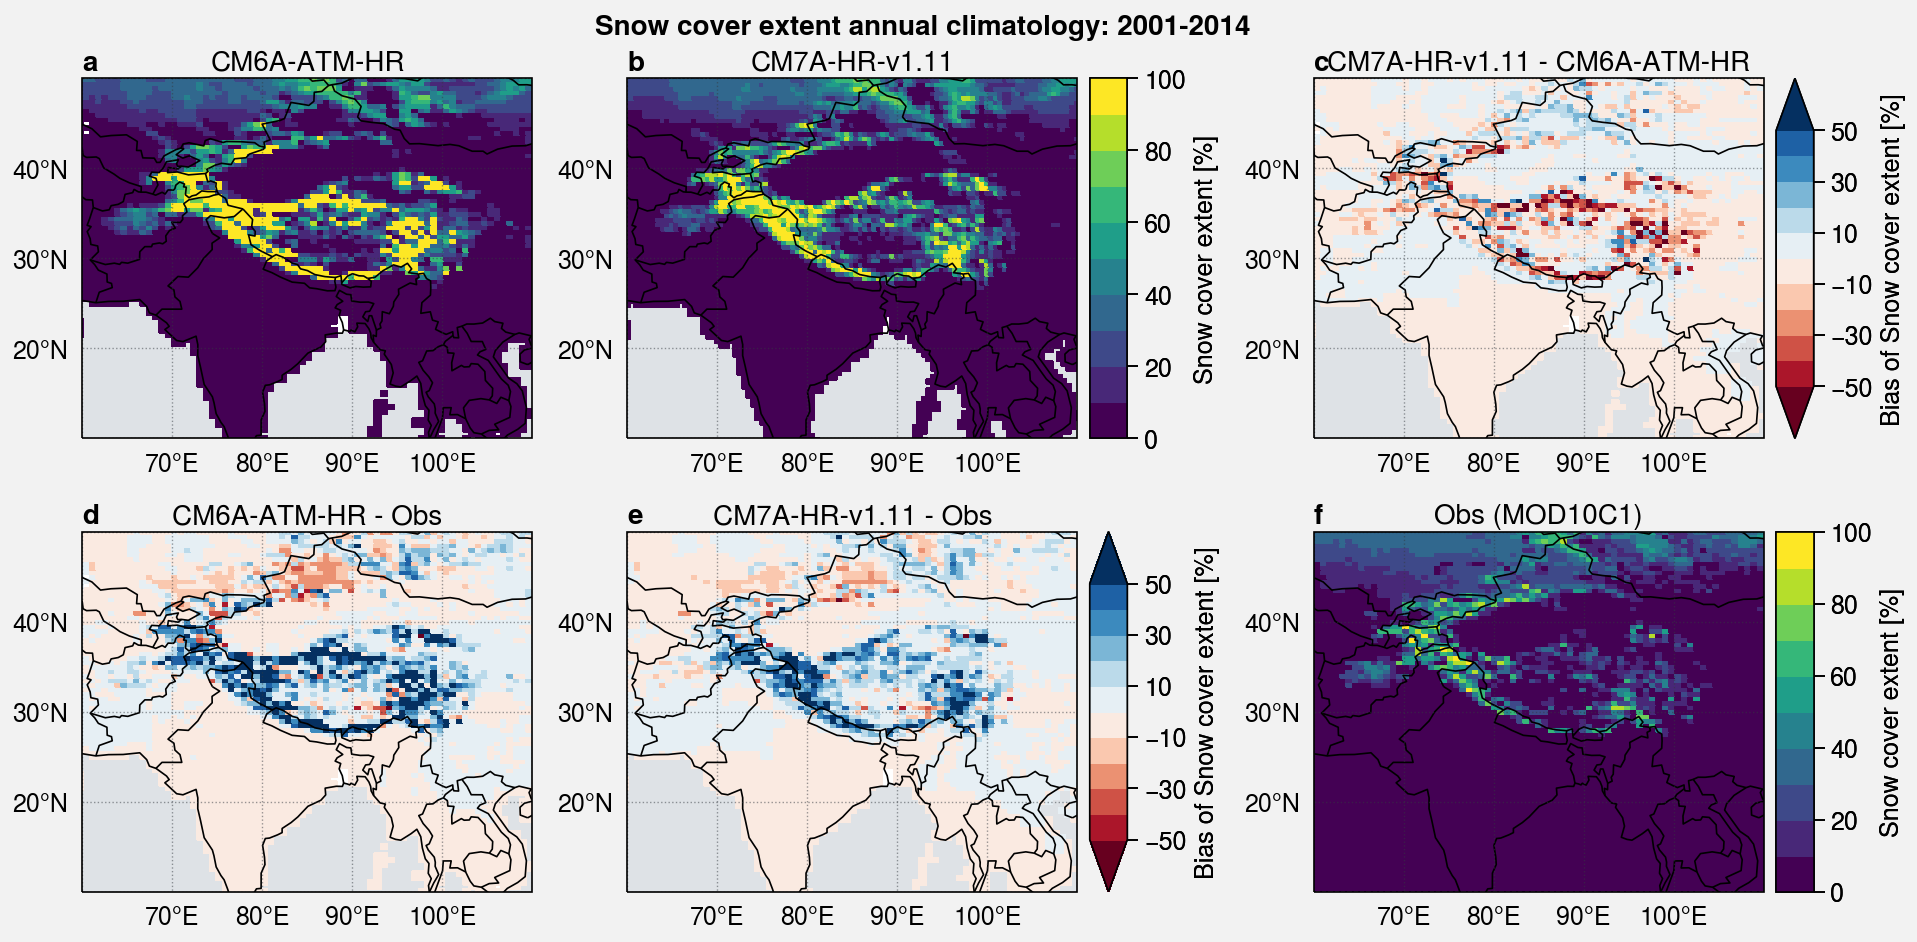

In [12]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-50,50,10)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

# First row: differences CM7A-HR-v1.11 / not guide
axs[0].pcolormesh(model_CM6_clim, cmap=cmap, levels=levels)
axs[0].format(title='CM6A-ATM-HR')

m1 = axs[1].pcolormesh(model_CM7_clim, cmap=cmap, levels=levels)
axs[1].format(title='CM7A-HR-v1.11')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_CM7_clim_regrid - model_CM6_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='CM7A-HR-v1.11 - CM6A-ATM-HR')
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: differences with obs

axs[3].pcolormesh(model_CM6_clim - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[3].format(title='CM6A-ATM-HR - Obs')

axs[4].pcolormesh(model_CM7_clim_regrid - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[4].format(title='CM7A-HR-v1.11 - Obs')
axs[4].colorbar(m2, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.png')
f.save('img/'+var+'_dynamico_MODIS_'+period.start+'-'+period.stop+'.pdf')